In [160]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D,Dropout, UpSampling2D, Conv2DTranspose,BatchNormalization,AveragePooling2D,ZeroPadding2D 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing import image
import tensorflow
import glob
from tqdm import tqdm
import warnings;
warnings.filterwarnings('ignore')
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
from time import time
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Reshape
from tensorflow.keras import Sequential
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.applications.vgg16 import VGG16
# load an image from file
import sys
from numpy import load
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.image import imread
from numpy import expand_dims

import pickle
from tensorflow.keras.preprocessing.image import array_to_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy import expand_dims
import numpy as np
import os

# Creating manipulated images for robust training set, testing set, validation set

In [628]:
datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    #preprocessing_function=preprocess_input,
    rescale=1/255)
    #rotation_range=1,
    #width_shift_range=1,
    #height_shift_range=10,
    #brightness_range=(.9,1.1),
    #shear_range=0.8,
    #zoom_range=[.8,1.1],
    #channel_shift_range=.1,
    #fill_mode="wrap",
    #horizontal_flip=False)

In [165]:
datagen.fit(X)

In [627]:
true_datagen = tensorflow.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255)

In [450]:
# setup generator
train_generator = datagen.flow_from_directory(
        directory=r"C:\Users\dedunn\Desktop\full_aerin",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='grayscale',
        batch_size=1,
        class_mode='input')

Found 484 images belonging to 44 classes.


In [8]:
true_generator = true_datagen.flow_from_directory(
        directory=r"C:\Users\dedunn\Desktop\full_aerin",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='grayscale',
        batch_size=1,
        class_mode=None)

Found 484 images belonging to 44 classes.


In [ ]:
valid_generator =datagen.flow_from_directory(
        directory=r"C:\Users\dedunn\Desktop\full_aerin_test",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=1,
        class_mode='categorical')

In [ ]:
true_valid_generator =true_datagen.flow_from_directory(
        directory=r"C:\Users\dedunn\Desktop\full_aerin_test",
        target_size=(IMG_SIZE, IMG_SIZE),
        color_mode='rgb',
        batch_size=1,
        class_mode='categorical')

In [840]:
IMG_SIZE=224

In [ ]:
X=X.reshape(-1,IMG_SIZE,IMG_SIZE,1)

# Directories where images are stored and building training sets

In [433]:
cat=os.listdir(r"C:\Users\dedunn\Desktop\full_aerin")

In [5]:
test=load_img(r"C:\Users\dedunn\Desktop\full_aerin\AERIN_AM_MOODBOARD_LR.jpg\AERIN_AM_MOODBOARD_LR.jpg")

In [841]:
training_data=[]

In [842]:
for image in range(len(cat)):
    test=(r"C:\Users\dedunn\Desktop\full_aerin\{}\{}").format(cat[image],cat[image])
    #test=load_img(r"C:\Users\dedunn\Desktop\full_aerin\{}\{}").format(cat[image],cat[image])
    img_array = cv2.imread(test)#,cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)).astype('float32')
    test_image = new_array[...,::-1]
    #test=load_img(test)
    #dims=expand_dims(test,0)
    #dims=cv2.resize(dims,(IMG_SIZE,IMG_SIZE)).astype('uint8')
    training_data.append(test_image)

In [770]:
X[8].shape

(28, 28, 1)

In [49]:
array_to_img(training_data[3])

In [457]:
# if i use the std normalization or featurwise settings on the image generator i need to fit it
datagen.fit(X)

In [851]:
# turn training data into array
X=np.array(training_data)

In [633]:
# reshape depending on color or grayscale
X=X.reshape(-1,IMG_SIZE,IMG_SIZE,1)

In [850]:
# normalize, only do if not using data generator, and then have to do for the Y input
X=X/255

In [852]:
X.shape

(44, 224, 224, 3)

In [ ]:
DATADIR=r"C:\Users\dedunn\Desktop\full_aerin"
CATEGORIES=cat

In [ ]:
# alternative way to create training data
def create_training_data():
    for category in CATEGORIES:
        path =  os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
                #img_array=img_to_array(img)
                #img_array=expand_dims(img_array, 0)
                new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE)).astype('float32')
                test_image = img_array[...,::-1]
                training_data.append([test_image,class_num])
            except Exception as e:
                pass
create_training_data()
#cv2.IMREAD_GRAYSCALE

# Auto encoding

In [123]:
# using conv2d, upsampling, mse, grayscale, 
Input_img = tensorflow.keras.Input(shape=(28, 28, 1),dtype='float32')  
    
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x3 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x3)

# decoding architecture
x4 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x5 = UpSampling2D((2, 2))(x4)
x6 = Conv2D(128, (3, 3), activation='relu', padding='same')(x5)
x7 = Conv2D(256, (3, 3), activation='relu', padding='same')(x6)
decoded = Conv2D(1, (3, 3),activation='sigmoid', padding='same')(x7)

autoencoder = Model([Input_img, decoded])
autoencoder.compile(optimizer='adam', loss='mse')

In [865]:
#early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=4, verbose=1, mode='auto')

#a_e = autoencoder.fit(X,X/255,
            #epochs=50,
            #shuffle=True,
            #steps_per_epoch=44,
            #validation_data=(X, X))
            #callbacks=[early_stopper])

In [26]:
# function to build autoencoder
def build_autoencoder(img_shape, code_size):
    # The encoder
    encoder = Sequential()
    encoder.add(InputLayer(img_shape))
    encoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    encoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    encoder.add(MaxPool2D( (2, 2)))
    #encoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    encoder.add(Flatten())
    encoder.add(Dense(code_size))

    # The decoder
    decoder = Sequential()
    decoder.add(InputLayer((code_size)))
    #decoder.add(Reshape(img_shape))
    decoder.add(UpSampling2D(interpolation='nearest'))
    decoder.add(Reshape(img_shape))
    decoder.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    decoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    #decoder.add(UpSampling2D((2,2)))
    #decoder.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    decoder.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    decoder.add(Flatten())
    #decoder.add(UpSampling2D(2,2))
    decoder.add(Dense(np.prod(img_shape))) # np.prod(img_shape) is the same as 32*32*3, it's more generic than saying 3072
    decoder.add(Reshape(img_shape))
    #decoder.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
    return encoder, decoder

In [868]:
# different way to run a function model
IMG_SHAPE = X.shape[1:]
#encoder, decoder = build_autoencoder(IMG_SHAPE, 32)

inp = Input(IMG_SHAPE)
#code = encoder(inp)
#reconstruction = decoder(code)

#autoencoder = Model(inp,reconstruction)
#autoencoder.compile(optimizer='adamax', loss='mse')

#print(autoencoder.summary())

In [870]:
#history = autoencoder.fit(x=X, y=X, epochs=20000,
                #validation_data=[X, X])

In [23]:
#ENCODER using differe sizes,transpose all different layers
#kernel_initializer='he_uniform' for relu
inp = Input((56, 56,1))
e = Conv2D(32, (3, 3), strides=1,activation='relu',padding='same')(inp)
#e = Conv2D(64, (3, 3), strides=2,activation='relu',padding='same')(e)
e = MaxPool2D((2, 2))(e)
#e = Conv2D(64, (3, 3),strides=2,padding='same', activation='relu')(e)
e = BatchNormalization()(e)
#e = MaxPool2D((2, 2))(e)
#e = Conv2D(64, (3, 3),strides=2, activation='relu',padding='same')(e)
e = AveragePooling2D((2,2))(e)
l = Flatten()(e)
l = Dense(128, activation='relu')(l)
l = Dense(64, activation='relu')(l)
l = Dense(16, activation='relu')(l)
#DECODER
d =Dense(784, activation='relu')(l)
d =Dense(1568, activation='relu')(l)
d =Dense(3136, activation='relu')(d)
d = Reshape((7,7,64))(d)
#d = ZeroPadding2D(padding=((0,0),(0,1)))(d)
#d = UpSampling2D()(d)
#d = Reshape((14,14,1))(d)
d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
d = Conv2DTranspose(128,(3, 3), strides =2,activation='relu', padding='same')(d)
d = BatchNormalization()(d)
#d = UpSampling2D()(d)
#d = Conv2DTranspose(64,(3, 3), strides=2, activation='relu', padding='same')(d)
#d = BatchNormalization()(d)
d = Conv2DTranspose(64,(3, 3),strides=2, activation='relu', padding='same')(d)
d = Conv2DTranspose(32,(3, 3), activation='relu', padding='same')(d)
#d = Reshape((28,28,1))(d)
#d = Dense(32, activation='relu')(d)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d)
ae = Model(inp, decoded)
ae.summary()
#Input to reshape is a tensor with 1408 values, but the requested shape has 1344

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 56, 56, 1)]       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 32)        320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
average_pooling2d_4 (Average (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               8029

In [548]:
# compile it using adam optimizer
#ae.compile(optimizer="adam", loss="mse")
#Train it by providing training images
#ae.fit(X, X, epochs=20000)

In [112]:
array_to_img(X[0])

In [853]:
Y=X/255

In [738]:
# another model structure
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(128, (3,3 ), activation='relu', padding='same')(input_img)
x = MaxPool2D((2, 2), padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3),strides=(2,2), activation='relu', padding='same')(x)
x = MaxPool2D((2, 2), padding='same')(x)
#x = Dropout(.5)(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3),strides=(1,1), activation='elu')(x)
x = BatchNormalization()(x)
x = AveragePooling2D((3, 3), padding='same')(x)
x = Flatten()(x)
x = Dense(256, activation = 'relu')(x)
encoded = Dense(128, activation = 'relu')(x)
#encoded = Dense(49, activation = 'relu')(x)
#encoded = Dense(512,activation='elu')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
#x = Dense(196, activation = 'elu')(encoded)
x= Reshape((4,4,8))(encoded)
#x = Conv2D(128, (3, 3),strides=(1,1), activation='elu', padding='same')(x)
x = Conv2DTranspose(128, (3, 3),strides=(2,2),activation='relu',padding='same' )(x)
x = BatchNormalization()(x)
#x = Conv2D(64, (3, 3),strides=(1,1), activation='elu', padding='same')(x)
x = Conv2DTranspose(256, (3, 3),strides=(2,2), activation='relu',padding='same' )(x)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='elu',padding='same')(x)
#x = BatchNormalization()(x)
#x = Conv2D(32, (3, 3),activation='elu')(x)
#x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(256, (3, 3),strides=(2,2), activation='elu',padding='same')(x)
#x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
#x= Reshape((28,28,3))(x)
decoded = Conv2D(1, (5, 5), activation='elu')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss="mse")

In [758]:
# dense layer model
input_img = Input(shape=(28, 28, 1))
#x = Conv2D(128, (3,3 ), activation='relu', padding='same')(input_img)
#x = MaxPool2D((2, 2), padding='same')(x)
#x = BatchNormalization()(x)
x = Flatten()(input_img)
x = Dense(785, activation = 'relu')(x)
x = Dense(390, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(x)
encoded = Dense(44, activation = 'relu')(x)
x = Dense(150, activation = 'relu')(encoded)
x = Dense(390, activation = 'relu')(x)
decoded = Dense(785, activation = 'sigmoid')(x)
#x= Reshape((28,28,1))(x)
#x = Conv2DTranspose(128, (3, 3),strides=(2,2),activation='relu',padding='same' )(x)
#decoded = Conv2D(1, (1, 1),strides=(1,1), activation='sigmoid')(x)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss="mse")

In [854]:
Input_img = Input(shape=(224,224, 3))  
    
#encoding architecture
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(Input_img)
x1 = BatchNormalization()(x1)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
x2 = BatchNormalization()(x2)
x2 = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
encoded = AveragePooling2D( (2, 2))(x2)

# decoding architecture
x3=Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x3 = Conv2DTranspose(64, (5, 5),strides=2, activation='relu', padding='same')(x3)
x3 = Conv2DTranspose(128, (3, 3),strides=(2,2),activation='relu',padding='same' )(x3)
#x3 = UpSampling2D((2, 2))(x3)
#x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x1 = Conv2DTranspose(256, (3, 3), activation='relu', padding='same')(x3)
decoded = Conv2D(3, (1, 1), padding='same')(x1)

autoencoder = Model(Input_img, decoded)
autoencoder.compile(optimizer='Nadam', loss='mse')

In [856]:
autoencoder.fit_generator(datagen.flow(X, Y, batch_size=1),
                    steps_per_epoch=len(X), epochs=50000)

  ...
    to  
  ['...']
Train for 44 steps
Epoch 1/50000
44/44 [==============================] - 66s 2s/step - loss: 0.1500
Epoch 2/50000
44/44 [==============================] - 65s 1s/step - loss: 0.0533
Epoch 3/50000
44/44 [==============================] - 64s 1s/step - loss: 0.0489
Epoch 4/50000
44/44 [==============================] - 64s 1s/step - loss: 0.0424
Epoch 5/50000
44/44 [==============================] - 65s 1s/step - loss: 0.0512
Epoch 6/50000
44/44 [==============================] - 71s 2s/step - loss: 0.0417
Epoch 7/50000
44/44 [==============================] - 66s 2s/step - loss: 0.0299
Epoch 8/50000
44/44 [==============================] - 69s 2s/step - loss: 0.0259
Epoch 9/50000
44/44 [==============================] - 67s 2s/step - loss: 0.0380
Epoch 10/50000
44/44 [==============================] - 67s 2s/step - loss: 0.0306
Epoch 11/50000
44/44 [==============================] - 67s 2s/step - loss: 0.0290
Epoch 12/50000
44/44 [==============================

KeyboardInterrupt: 

In [125]:
#autoencoder.fit((train_generator, train_generator),
                #steps_per_epoch=44,
                #epochs=500000)
                #batch_size=128,
                #shuffle=False)
                #validation_data=(x_test, x_test),
                #callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [416]:
from tensorflow.keras import models

In [863]:
autoencoder.save('autoencoder_size_224_3.h5')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

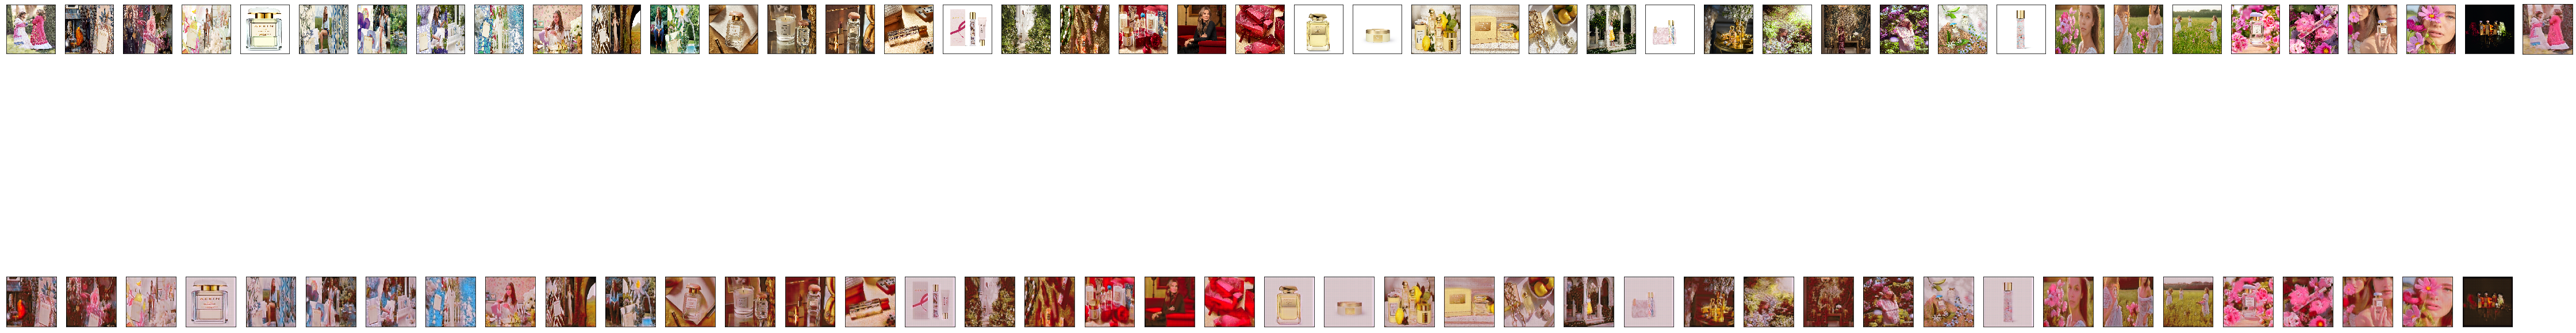

In [857]:
# visualizing encoded vs true images
decoded_imgs = autoencoder.predict(Y)

n = 43
plt.figure(figsize=(80, 16))
for i in range(n):
    # display original
    ax = plt.subplot(2, n+1, i+1)
    #ax = plt.subplot(2, n, i + n)
    plt.imshow(np.array(Y[i]).reshape(224, 224,3))
    #plt.imshow(X[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n+1, i+1)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(np.array(decoded_imgs[i]).reshape(224, 224,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
array_to_img(autoencoder.predict(np.array(X[1].reshape(1,28,28,1))))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


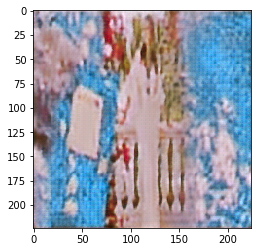

In [862]:
plt.imshow(np.array(decoded_imgs[8]).reshape(224, 224,3))

In [71]:
from tensorflow.keras.models import load_model

In [72]:
from tensorflow.keras.models import load_model

In [73]:
model=load_model(r"C:\Users\dedunn\Desktop\weights-val_74-0.98.hdf5")

In [74]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      2432      
_________________________________________________________________
dropout (Dropout)            (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 221, 221, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 221, 221, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 221, 221, 32)      128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 110, 110, 32)      0

In [ ]:
model=Sequential()
model.add(tensorflow.keras.layers.Conv2D(input_shape=(224,224,3),filters=32, kernel_size=(5,5),activation="relu", padding="same")),
model.add(tensorflow.keras.layers.Dropout(0.5)),
model.add(tensorflow.keras.layers.BatchNormalization(axis=-1)),
#model.add(tensorflow.keras.layers.Activation("relu")),
model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(5, 5), strides=(1,1), padding='valid')),
#model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu")),
#model.add(tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same",activation="relu")),
#model.add(tensorflow.keras.layers.Dropout(0.5)),
#model.add(tensorflow.keras.layers.BatchNormalization(axis=-1)),
#model.add(tensorflow.keras.layers.Activation("relu")),
#model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(1,1), padding='valid')),
#model.add(tensorflow.keras.layers.Dropout(0.5)),
#model.add(tensorflow.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding="same",activation="relu")),
model.add(tensorflow.keras.layers.BatchNormalization(axis=-1)),
#model.add(tensorflow.keras.layers.Activation("relu")),
#model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')),
#model.add(tensorflow.keras.layers.AveragePooling2D(pool_size=(4, 4), strides=(1,1), padding='valid')),
#model.add(tensorflow.keras.layers.Dropout(0.5)),
#model.add(tensorflow.keras.layers.Conv2D(filters=224, kernel_size=(3,3), padding="same", activation="relu")),
#model.add(tensorflow.keras.layers.Dropout(0.5)),
#model.add(tensorflow.keras.layers.BatchNormalization(axis=-1)),
#model.add(tensorflow.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='valid')),
model.add(tensorflow.keras.layers.AveragePooling2D(pool_size=(2, 2), strides=None, padding='valid', data_format=None)),
model.add(tensorflow.keras.layers.Flatten()),
model.add(tensorflow.keras.layers.Dense(44, activation='softmax')),